<a href="https://colab.research.google.com/github/wbandabarragan/EPIC_4/blob/main/Day_3/tutorial6_cfd_grids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 6: Analysis and Visualisation of meshgrids used in CFD for I/O

In this tutorial we will look into I/O functions, data analysis tools, and scientific visualisation packages, written in python and used for studying fluids.

It is important to use standard formats when you share data with colleagues or the community (e.g. via catalogues). This is so that they can also analyse the data or visualise it via commonly-used software packages for CFD rendering.

As a preliminar task, we will install the VisIt visualisation tools, which widely used by the CFD community accross fields (physics, astrophysics, engineering, etc). To do this, you can go to this webpage and download a version suitable for the OS of your PCs/laptops.

### Download VisIt:

https://visit-dav.github.io/visit-website/releases-as-tables/#latest

In the first example below, we will write files in a scientific data format that can then be used in VisIt. VisIt uses python in the backend, but it has a nice GUI interface. I recommend using VisIt for inspecting and visualising the data. I do **NOT** recommend to use the GUI for data analysis. If you need to do data analysis, you are better off with coding the pipeline yourself in Python.

### Some data:

https://drive.google.com/drive/folders/1OuvYFgOSQtE3S0ExUqZsaAwEtMxOA2Wt?usp=sharing

In [1]:
# Mount GDrive for I/O

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyevtk

In [3]:
# Importing modules

import numpy as np
import matplotlib.pyplot as plt
from pyevtk.hl import gridToVTK
import pyevtk
import h5py

## Part A: Saving simulation arrays as HDF5 datasets

### About the Hierarchical Data Format v5 (HDF5):

This is also a self-descriptive format, which is widely used in many physics sub-fields because of its versatility.

- Data stored here can be very large!

- Data don't have to be of the same type, you can save numbers, units, strings, images, etc, all in the same file.

- It uses the structure of a file directory, organising information in GROUPS.

- GROUPS are then comprised of data fields with their own metadata.

See: https://www.hdfgroup.org/

### Practical problem:

Let's consider the advection simulation we carried out a couple of days ago. Here, we will run it again and modify the code to output H5 files, instead of PNG images.

In [4]:
# Domain setup
nx = ny = 256        # Number of grid points
lx = ly = 10.0       # Domain size
dx = dy = lx / nx    # Grid spacing
v_x, v_y = 3.0, 0.   # Velocities in x and y directions

# Time discretisation
dt = 0.01
nt = 150                  # Number of time steps

# Initialize grid
x = y = np.linspace(-lx, lx, nx)

# Meshgrid
x_2d, y_2d = np.meshgrid(x, y, indexing='ij')

# Initial condition:
rho_0 = 5*np.exp(-x_2d**2/6)

In [5]:
# Apply FFT method for 2D advection
def fft_advection(u0, vx, vy, dt, nt):

    # Go to Fourier frequency domain
    u_hat = np.fft.fft2(u0)
    kx = ky = 2 * np.pi * np.fft.fftfreq(nx, d=dx)
    kx_2d, ky_2d = np.meshgrid(kx, ky, indexing='ij')

    # Advection in Fourier domain
    for n in range(1, nt+1):

        # Compute advection term
        u_hat = u_hat * np.exp(-1j * (vx * kx_2d + vy * ky_2d) * dt)

    # Transform back to spatial domain
    rhs_ode = np.fft.ifft2(u_hat).real

    return rhs_ode

In [6]:
for j in range(0, nt+1):

    # Compute the final state
    u_final = fft_advection(rho_0, v_x, v_y, dt, j)

    # Export H5 file
    hf = h5py.File('/content/drive/MyDrive/Colab Notebooks/EPIC_4/wave_data{:03d}.h5'.format(j), 'w')
    hf.create_dataset('dens', data=u_final.T)
    hf.create_dataset('X', data=x_2d)
    hf.create_dataset('Y', data=y_2d)
    hf.close()

## Part B: Saving data into VTK files

### About the Visualization ToolKit (VTK) format

This format is an open-source data format, developed by Kitware, and widely used in computational fluid dynamics and computer graphics applications. There are two sub-formats, legacy and XML.

VTK file structure:

- File version and ID.

- Header, comments with informaton on the dataset.

- Data type, which can be Binary or ASCII.

- Domain structure, mesh/grid information:

DATASET

- STRUCTURED_GRID

- UNSTRUCTURED_GRID

- RECTILINEAR_GRID

- POLYDATA

- FIELD

- Coordinates, Dimensions, Grid spacing.

- Attributes

- Values stored at grid cells, e.g. scalars, vectors, tensors.

See: https://vtk.org


### Practical problem:

Let's consider a new problem where we want to generate two turbulent fields:

- A scalar field that represents a random (clumpy) density field.
- A 3D vector field that represents a Gaussian velocity field.

In [7]:
from scipy.ndimage import gaussian_filter
from skimage.transform import resize

In [8]:
# Parameters
mu = 1.0
ss = 0.2
cc = 2.0

# Define the dimensions of the 2D image
nx, ny, nz = 100, 100, 100

# Create a 2D array representing the image (for example, a simple gradient)
image_data = np.linspace(0, 1, nx * ny * nz).reshape((nx, ny, nz))

rho_turb = np.random.normal(mu, ss, (nx, ny, nz))

# Apply a Gaussian filter to create clumpiness
clump_turb = gaussian_filter(rho_turb, cc)

vx = np.random.uniform(-1, 1, (nx, ny, nz))/clump_turb
vy = np.random.uniform(-1, 1, (nx, ny, nz))/clump_turb

dens = image_data*clump_turb

# Create coordinates for the grid
x = np.arange(0, nx + 1)
y = np.arange(0, ny + 1)
z = np.arange(0, nz + 1)

# Reshape the image_data to match the grid dimensions
dens = dens.reshape((nx, ny, nz))

# Export the data to a VTK file
gridToVTK("/content/drive/MyDrive/Colab Notebooks/EPIC_4/clumpy_gas", x, y, z, cellData={"density": dens, "vel_x": vx, "vel_y": vy})

'/content/drive/MyDrive/Colab Notebooks/EPIC_4/new107.vtr'

In [56]:
from scipy.special import sph_harm

In [57]:
# Define grid dimensions
nx, ny, nz = 100, 100, 100

# Create a 3D grid of points
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
z = np.linspace(-1, 1, nz)

# Obtain meshgrid in 3D
x, y, z = np.meshgrid(x, y, z, indexing='ij')

# Convert Cartesian coordinates to spherical coordinates
r = np.sqrt(x**2 + y**2 + z**2)
theta = np.arccos(z / (r + 1e-10))  # Avoid division by zero
phi = np.arctan2(y, x)

# Define spherical harmonic parameters
l = 3
m = 2

# Compute the spherical harmonics on the grid
Y_lm = sph_harm(m, l, phi, theta)

# Take the absolute value to get a real scalar field
data = np.abs(Y_lm)

# Mask out the regions where r > 1 (outside the unit sphere)
data[r > 1] = 0

# Convert to Fortran order for VTK compatibility
data_fortran = np.asfortranarray(data.real)

# Define grid coordinates for VTK
x_coords = np.linspace(-1, 1, nx)
y_coords = np.linspace(-1, 1, ny)
z_coords = np.linspace(-1, 1, nz)

# Save to a VTK file
gridToVTK("/content/drive/MyDrive/Colab Notebooks/EPIC_4/spherical_harmonic", x_coords, y_coords, z_coords, pointData={"spherical_harmonic": data_fortran})


'/content/drive/MyDrive/Colab Notebooks/EPIC_4/spherical_harmonic.vtr'

## Part C: Reading CFD data in HDF5 format using YT

### About YT


The yt package in Python is a versatile and powerful open-source library designed for analyzing and visualizing volumetric data across multiple scientific disciplines, including fluid dynamics, astrophysics, etc.

It supports a wide range of data formats and simulation codes, enabling users to perform complex data analysis tasks such as creating projections, slices, and profiles. yt allows for seamless manipulation of data with its intuitive API, and it integrates well with other scientific libraries like NumPy and Matplotlib.

Additionally, yt offers robust capabilities for generating high-quality visualizations, facilitating both qualitative and quantitative analysis of multi-dimensional datasets.

See: https://yt-project.org/

In [9]:
!pip install yt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.1/126.1 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.4 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.7
    Uninstalling widgetsnbextension-3.6.7:
      Successfully uninstalled widgetsnbextension-3.6.7
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [10]:
import yt

In [11]:
ds = yt.load_sample("DensTurbMag")

/usr/local/lib/python3.10/dist-packages/yt/sample_data/api.py:149: UserWarning: Storage directory from yt config doesn't exist (currently set to '/does/not/exist'). Current working directory will be used instead.
  warn(
yt : [INFO     ] 2024-07-24 11:03:06,312 'DensTurbMag' is not available locally. Looking up online.
yt : [INFO     ] 2024-07-24 11:03:06,323 Downloading from https://yt-project.org/data/DensTurbMag.tar.gz
100%|██████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 187MB/s]
yt : [INFO     ] 2024-07-24 11:03:06,978 Untaring downloaded file to '/content'
yt : [INFO     ] 2024-07-24 11:03:07,797 Parameters: current_time              = 751000000000.0
yt : [INFO     ] 2024-07-24 11:03:07,809 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2024-07-24 11:03:07,813 Parameters: domain_left_edge          = [-2.e+18 -2.e+18 -2.e+18]
yt : [INFO     ] 2024-07-24 11:03:07,819 Parameters: domain_right_edge         = [2.e+18 2.e+18 2.e+18]
yt : [INFO     ] 2

### Load dataset:

In [12]:
ds.print_stats()

level	# grids	       # cells	     # cells^3
----------------------------------------------
  0	     1	           512	             8
  1	     8	          4096	            16
  2	    64	         32768	            32
----------------------------------------------
   	    73	         37376


t = 7.51000000e+11 code_time = 7.51000000e+11 s = 2.37977539e+04 yr

Smallest Cell:
	Width: 4.051e-08 Mpc
	Width: 4.051e-02 pc
	Width: 8.356e+03 AU
	Width: 1.250e+17 cm


In [13]:
ds.field_list

[('flash', 'dens'),
 ('flash', 'ener'),
 ('flash', 'gpot'),
 ('flash', 'pres'),
 ('flash', 'temp'),
 ('flash', 'velx'),
 ('flash', 'vely'),
 ('flash', 'velz')]

In [14]:
ds.derived_field_list

[('flash', 'cell_volume'),
 ('flash', 'dens'),
 ('flash', 'dx'),
 ('flash', 'dy'),
 ('flash', 'dz'),
 ('flash', 'ener'),
 ('flash', 'gpot'),
 ('flash', 'path_element_x'),
 ('flash', 'path_element_y'),
 ('flash', 'path_element_z'),
 ('flash', 'pres'),
 ('flash', 'temp'),
 ('flash', 'velx'),
 ('flash', 'vely'),
 ('flash', 'velz'),
 ('flash', 'volume'),
 ('flash', 'x'),
 ('flash', 'y'),
 ('flash', 'z'),
 ('gas', 'angular_momentum_magnitude'),
 ('gas', 'angular_momentum_x'),
 ('gas', 'angular_momentum_y'),
 ('gas', 'angular_momentum_z'),
 ('gas', 'averaged_density'),
 ('gas', 'baroclinic_vorticity_magnitude'),
 ('gas', 'baroclinic_vorticity_x'),
 ('gas', 'baroclinic_vorticity_y'),
 ('gas', 'baroclinic_vorticity_z'),
 ('gas', 'cell_mass'),
 ('gas', 'cell_volume'),
 ('gas', 'courant_time_step'),
 ('gas', 'cutting_plane_velocity_x'),
 ('gas', 'cutting_plane_velocity_y'),
 ('gas', 'cutting_plane_velocity_z'),
 ('gas', 'density'),
 ('gas', 'density_gradient_magnitude'),
 ('gas', 'density_gradie

In [15]:
print(ds.field_info['gas', 'averaged_density'].get_source())

    def _averaged_field(field, data):
        def atleast_4d(array):
            if array.ndim == 3:
                return array[..., None]
            else:
                return array

        nx, ny, nz, ngrids = atleast_4d(data[(ftype, basename)]).shape
        new_field = data.ds.arr(
            np.zeros((nx - 2, ny - 2, nz - 2, ngrids), dtype=np.float64),
            (just_one(data[(ftype, basename)]) * just_one(data[(ftype, weight)])).units,
        )
        weight_field = data.ds.arr(
            np.zeros((nx - 2, ny - 2, nz - 2, ngrids), dtype=np.float64),
            data[(ftype, weight)].units,
        )
        i_i, j_i, k_i = np.mgrid[0:3, 0:3, 0:3]

        for i, j, k in zip(i_i.ravel(), j_i.ravel(), k_i.ravel()):
            sl = (
                slice(i, nx - (2 - i)),
                slice(j, ny - (2 - j)),
                slice(k, nz - (2 - k)),
            )
            new_field += (
                atleast_4d(data[(ftype, basename)])[sl]
                * atl

In [16]:
print(ds.domain_width.in_units("kpc"))
print(ds.domain_width.in_units("au"))

[0.00129631 0.00129631 0.00129631] kpc
[267383.4848 267383.4848 267383.4848] AU


In [17]:
#print(ds.index.grid_left_edge)

ds.index.grids[1]

FLASHGrid_0002 ([8 8 8])

In [18]:
g = ds.index.grids[1]
print(g)

FLASHGrid_0002 ([8 8 8])


In [19]:
g.ActiveDimensions

array([8, 8, 8], dtype=int32)

In [20]:
g.LeftEdge, g.RightEdge

(unyt_array([-2.e+18, -2.e+18, -2.e+18], 'code_length'),
 unyt_array([0., 0., 0.], 'code_length'))

In [21]:
g.Level

1

In [22]:
g.Children

[FLASHGrid_0003 ([8 8 8]),
 FLASHGrid_0004 ([8 8 8]),
 FLASHGrid_0005 ([8 8 8]),
 FLASHGrid_0006 ([8 8 8]),
 FLASHGrid_0007 ([8 8 8]),
 FLASHGrid_0008 ([8 8 8]),
 FLASHGrid_0009 ([8 8 8]),
 FLASHGrid_0010 ([8 8 8])]

In [23]:
gs = ds.index.select_grids(ds.index.max_level)
g2 = gs[0]
print(g2)
print(g2.Parent)
print(g2.get_global_startindex())

FLASHGrid_0003 ([8 8 8])
FLASHGrid_0002 ([8 8 8])
[0 0 0]


In [24]:
g2["density"][:, :, 0]
print((g2.Parent.child_mask == 0).sum() * 8)
print(g2.ActiveDimensions.prod())

4096
512


In [25]:
for f in ds.field_list:
    fv = g[f]
    if fv.size == 0:
        continue
    print(f, fv.min(), fv.max())

('flash', 'dens') 7.558611969477159e-24 code_mass/code_length**3 2.475221176115155e-20 code_mass/code_length**3
('flash', 'ener') 971575680.0 code_length**2/code_time**2 88982421504.0 code_length**2/code_time**2
('flash', 'gpot') -517364547584.0 code_length**2/code_time**2 -512310083584.0 code_length**2/code_time**2
('flash', 'pres') 3.690514690721236e-13 code_mass/(code_length*code_time**2) 1.3421905947774704e-11 code_mass/(code_length*code_time**2)
('flash', 'temp') 15.0 code_temperature 1629.218994140625 code_temperature
('flash', 'velx') -51084.109375 code_length/code_time 52800.4765625 code_length/code_time
('flash', 'vely') -64813.7109375 code_length/code_time 66758.765625 code_length/code_time
('flash', 'velz') -63283.890625 code_length/code_time 54444.3984375 code_length/code_time


In [26]:
sp = ds.sphere("max", (10, "kpc"))

yt : [INFO     ] 2024-07-24 11:03:11,222 max value is 4.90329e-20 at 187500000000000000.0000000000000000 -62500000000000000.0000000000000000 187500000000000000.0000000000000000


In [27]:
list(sp.quantities.keys())

['WeightedAverageQuantity',
 'TotalQuantity',
 'TotalMass',
 'CenterOfMass',
 'BulkVelocity',
 'WeightedStandardDeviation',
 'AngularMomentumVector',
 'Extrema',
 'SampleAtMaxFieldValues',
 'MaxLocation',
 'SampleAtMinFieldValues',
 'MinLocation',
 'SpinParameter']

In [28]:
sp.quantities.total_mass()

unyt_array([9.97347095e+34, 0.00000000e+00], 'g')

yt : [INFO     ] 2024-07-24 11:03:11,416 xlim = -2000000000000000000.000000 2000000000000000000.000000
yt : [INFO     ] 2024-07-24 11:03:11,424 ylim = -2000000000000000000.000000 2000000000000000000.000000
yt : [INFO     ] 2024-07-24 11:03:11,436 xlim = -2000000000000000000.000000 2000000000000000000.000000
yt : [INFO     ] 2024-07-24 11:03:11,442 ylim = -2000000000000000000.000000 2000000000000000000.000000
yt : [INFO     ] 2024-07-24 11:03:11,453 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



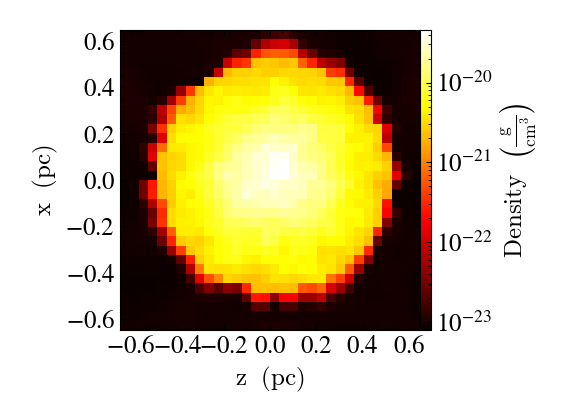

<Figure size 1000x800 with 0 Axes>

In [29]:
# Save the plot with a specified figure size
fig = plt.figure(figsize=(10, 8))  # width, height in inches
p = yt.SlicePlot(ds, "y", ("gas", "density"))
p.set_figure_size(3)
p.set_cmap(("gas", "density"), "hot")
p.show()


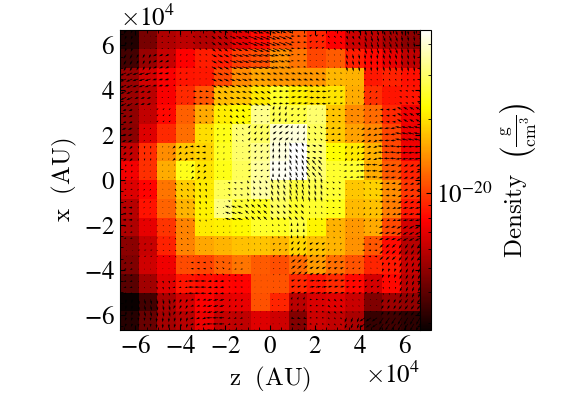

In [30]:
p.zoom(2.0)
p.annotate_velocity()
p.set_figure_size(3)

yt : [INFO     ] 2024-07-24 11:03:19,424 max value is 4.90329e-20 at 187500000000000000.0000000000000000 -62500000000000000.0000000000000000 187500000000000000.0000000000000000
yt : [INFO     ] 2024-07-24 11:03:19,471 xlim = -2062500000000000000.000000 1937500000000000000.000000
yt : [INFO     ] 2024-07-24 11:03:19,484 ylim = -1812500000000000000.000000 2187500000000000000.000000
yt : [INFO     ] 2024-07-24 11:03:19,501 xlim = -2062500000000000000.000000 1937500000000000000.000000
yt : [INFO     ] 2024-07-24 11:03:19,511 ylim = -1812500000000000000.000000 2187500000000000000.000000
yt : [INFO     ] 2024-07-24 11:03:19,515 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



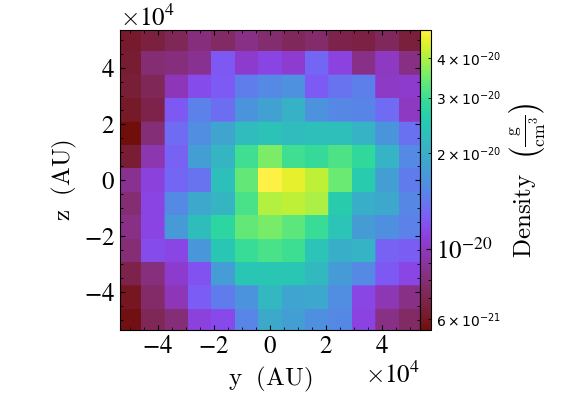

In [31]:
p = yt.SlicePlot(ds, "x", ("gas", "density"), center="max")
p.set_figure_size(3)
p.annotate_contour(("gas", "temperature"))
p.zoom(2.5)

## Part D: Sedov Solution: I/O of HDF5 data


### About the Sedov solution:

The Sedov problem, also known as the Sedov-Taylor blast wave solution, is a classic problem in fluid dynamics and astrophysics that describes the self-similar solution of a strong explosion in a medium with uniform density.

This model is particularly relevant in the study of supernova explosions and **shock waves**. It assumes an instantaneous release of energy at a point, resulting in a spherical shock wave that propagates outward.

The Sedov solution is derived from the conservation laws of mass, momentum, and energy, yielding a self-similar profile for the density, pressure, and velocity of the expanding shock.

The key feature of the Sedov solution is that the radius of the shock front grows proportionally to the time to the power of two-fifths ($R \propto t^{2/5}$), providing a fundamental framework for understanding explosive phenomena in astrophysical contexts.

In [32]:
ds = yt.load("/content/drive/MyDrive/Colab Notebooks/Sedov_3d/sedov_hdf5_chk_0002")

yt : [INFO     ] 2024-07-24 11:03:23,940 Particle file found: sedov_hdf5_chk_0002
yt : [INFO     ] 2024-07-24 11:03:24,931 Parameters: current_time              = 0.02006885654207998
yt : [INFO     ] 2024-07-24 11:03:24,946 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2024-07-24 11:03:24,951 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-07-24 11:03:24,953 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-07-24 11:03:24,959 Parameters: cosmological_simulation   = 0


In [33]:
ds.print_stats()

level	# grids	       # cells	     # cells^3
----------------------------------------------
  0	     1	           512	             8
  1	     8	          4096	            16
  2	    64	         32768	            32
  3	   512	        262144	            64
  4	  1088	        557056	            83
----------------------------------------------
   	  1673	        856576


t = 2.00688565e-02 code_time = 2.00688565e-02 s = 6.35943688e-10 yr

Smallest Cell:
	Width: 2.532e-27 Mpc
	Width: 2.532e-21 pc
	Width: 5.222e-16 AU
	Width: 7.812e-03 cm


In [34]:
print(ds.field_info)

{('flash', 'dens'): On-Disk Field ('flash', 'dens'): (units: 'code_mass/code_length**3'), ('gas', 'density'): Alias Field for ('flash', 'dens') ('gas', 'density'): (units: 'g/cm**3'), ('flash', 'eint'): On-Disk Field ('flash', 'eint'): (units: 'code_length**2/code_time**2'), ('flash', 'ener'): On-Disk Field ('flash', 'ener'): (units: 'code_length**2/code_time**2'), ('flash', 'gamc'): On-Disk Field ('flash', 'gamc'): (units: '', display_name: '\\gamma_c\\ \\rm{(ratio\\ of\\ specific\\ heats)}'), ('flash', 'game'): On-Disk Field ('flash', 'game'): (units: '', display_name: '\\gamma_e\\ \\rm{(ratio\\ of\\ specific\\ heats)}'), ('flash', 'pres'): On-Disk Field ('flash', 'pres'): (units: 'code_mass/(code_length*code_time**2)'), ('gas', 'pressure'): Alias Field for ('flash', 'pres') ('gas', 'pressure'): (units: 'dyn/cm**2'), ('flash', 'temp'): On-Disk Field ('flash', 'temp'): (units: 'code_temperature'), ('gas', 'temperature'): Alias Field for ('flash', 'temp') ('gas', 'temperature'): (units

In [35]:
ad = ds.all_data()

print(ad['flash', 'dens'].shape)


(749568,)


In [36]:
# Check available fields
print("Available fields:", ds.field_list)

Available fields: [('flash', 'dens'), ('flash', 'eint'), ('flash', 'ener'), ('flash', 'gamc'), ('flash', 'game'), ('flash', 'pres'), ('flash', 'temp'), ('flash', 'velx'), ('flash', 'vely'), ('flash', 'velz')]


### Part E: A word on adaptive mesh refinement (AMR) grids:

Adaptive Mesh Refinement (AMR) grids are a computational technique used in numerical simulations to dynamically adjust the resolution of the grid based on the complexity of the underlying data.

This method allows for higher resolution in regions with complex features, such as shock fronts or boundary layers, while maintaining lower resolution in less dynamic areas.

By focusing computational resources where they are needed most, AMR grids improve the efficiency and accuracy of simulations without the prohibitive costs associated with uniformly high-resolution grids.

This adaptability makes AMR particularly valuable in fields like astrophysics, fluid dynamics, and climate modeling, where phenomena of interest often occur over a wide range of spatial and temporal scales.

In [37]:
# Check the number of levels of refinement
max_refinement_level = ds.max_level
print(f"Maximum refinement level: {max_refinement_level}")

Maximum refinement level: 4


yt : [INFO     ] 2024-07-24 11:03:30,078 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-24 11:03:30,084 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-24 11:03:30,095 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-24 11:03:30,101 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-24 11:03:30,117 Making a fixed resolution buffer of (('flash', 'dens')) 800 by 800



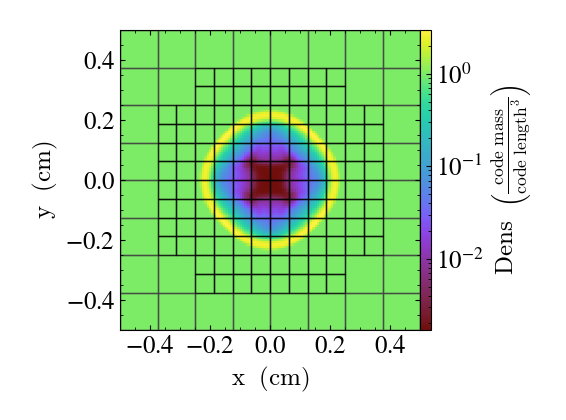

In [38]:
slice_plot = yt.SlicePlot(ds, "z", ('flash', 'dens'))

# Create a slice plot (for example, a slice along the z-axis)
#slice_plot = yt.SlicePlot(ds, 'z', 'density')

slice_plot.set_figure_size(3)

# Optionally, you can customize the plot (e.g., add mesh lines)
slice_plot.annotate_grids()

# Show the plot
slice_plot.show()


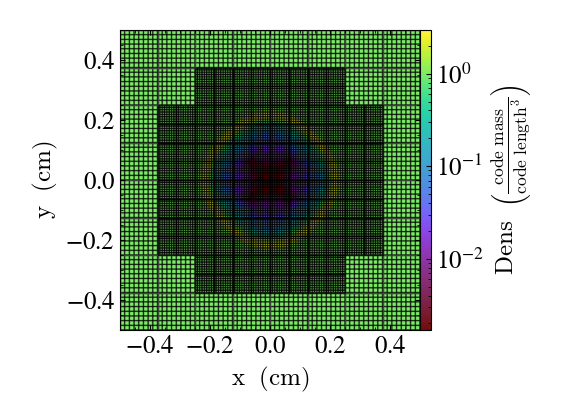

In [39]:
slice_plot.annotate_cell_edges()

### Calculating averages in problems with AMR grids:

In [40]:
# Function to compute the mean density value across all refinement levels
def calculate_mean_density(ds, field='ener'):
    total_density = 0
    total_volume = 0

    for level in range(max_refinement_level + 1):
        # Define the region for the current refinement level
        # Here we use the entire dataset; modify as necessary if refinement level filtering is required
        region = ds.all_data()

        # Extract density data
        density = region[field]

        # Compute volume of the cells at this refinement level
        # For simplicity, assuming uniform cell volume; adjust if necessary
        cell_volume = np.prod(ds.domain_right_edge - ds.domain_left_edge) / (2 ** level)

        # Accumulate total density and volume
        total_density += np.sum(density) * cell_volume
        total_volume += density.size * cell_volume

    # Compute mean density
    mean_density = total_density / total_volume

    return mean_density

In [41]:
# Calculate the mean density value
mean_density = calculate_mean_density(ds, field='ener')
print(f"Mean density value: {mean_density}")

Mean density value: 60.118973479650556 code_length**2/code_time**2


### Part F: Temporal analysis using YT and loops:

Instead of loading a single dataset, we'll load a bunch which we'll examine in sequence. This command creates a DatasetSeries object, which can be iterated over and analyzed.

Note that you can specify either a list of filenames, or a glob (i.e., asterisk) pattern in this.

### Practical example:

Let's find the min and max of the density as a function of time in this simulation. To do this we use the construction for ds in ts where ds means "Dataset" and ts is the "Time Series" we just loaded up.

For each dataset, we'll create an object (ad) that covers the entire domain (all_data is a shorthand function for this.) We'll then call the extrema Derived Quantity, and append the min and max to our extrema outputs.

Lastly, we're turn down yt's logging to only show "error"s so as to not produce too much logging text, as it loads each individual dataset below.

See more: https://yt-project.org

In [45]:
ts = yt.load_sample("enzo_tiny_cosmology/DD????/DD????")

/usr/local/lib/python3.10/dist-packages/yt/sample_data/api.py:149: UserWarning: Storage directory from yt config doesn't exist (currently set to '/does/not/exist'). Current working directory will be used instead.
  warn(
yt : [INFO     ] 2024-07-24 11:04:46,897 'enzo_tiny_cosmology/DD????/DD????' is not available locally. Looking up online.
yt : [INFO     ] 2024-07-24 11:04:46,901 Downloading from https://yt-project.org/data/enzo_tiny_cosmology.tar.gz
100%|███████████████████████████████████████| 439M/439M [00:00<00:00, 54.4GB/s]
yt : [INFO     ] 2024-07-24 11:05:01,018 Untaring downloaded file to '/content'


In [46]:
# Error messages will only be shown during the execution of yt scripts and operations.
yt.set_log_level("error")

# Create empty lists to store time-dependent data
rho_ex = []
times = []

for ds in ts:
    ad = ds.all_data()
    rho_ex.append(ad.quantities.extrema("density"))
    times.append(ds.current_time.in_units("Gyr"))

rho_ex = np.array(rho_ex)

Parsing Hierarchy : 100%|██████████| 211/211 [00:00<00:00, 6536.56it/s]


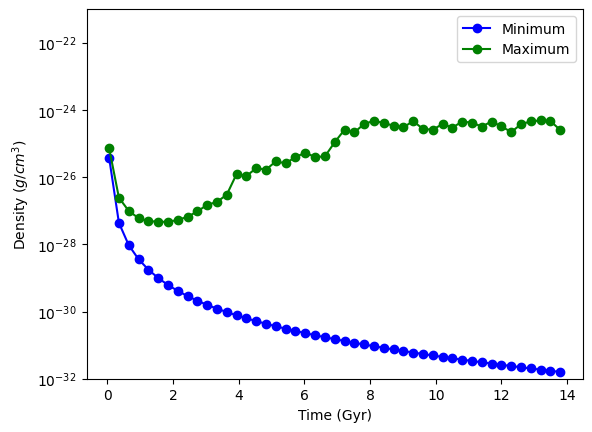

In [54]:
# Plotting

fig, ax = plt.subplots()

ax.set(
    xlabel="Time (Gyr)",
    ylabel="Density ($g/cm^3$)",
    yscale="log",
    ylim=(1e-32, 1e-21),
)

ax.plot(times, rho_ex[:, 0], "-o", color = "blue", label="Minimum")
ax.plot(times, rho_ex[:, 1], "-o", color = "green", label="Maximum")

ax.legend()

plt.show()


## Part G: Finding shocks in simulations with pyvista


PyVista is a powerful and versatile open-source library in Python designed for 3D visualization and mesh analysis.

Built on top of the Visualization Toolkit (VTK), PyVista provides an intuitive and user-friendly interface for creating, manipulating, and visualizing complex 3D data structures.

It supports a wide range of data formats and offers extensive functionality for mesh generation, surface and volume rendering, and data post-processing.

PyVista's integration with NumPy and other scientific computing libraries makes it a valuable tool for researchers and engineers in fields such as computational fluid dynamics, structural analysis, and medical imaging.

Its ability to produce high-quality, interactive 3D visualizations makes it an excellent choice for both exploratory data analysis and presentation.

In [60]:
!pip install pyvista

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 MB 7.5 MB/s eta 0:00:00


### The Orszag-Tang vortex:

We want to study the properties of turbulent flows using numerical calculus and Fourier analysis. Let us consider the Orszag-Tang vortex system, which describes a doubly periodic fluid configuration leading to 2D supersonic magnetohydrodynamical (MHD) turbulence. Although an analytical solution is not known, its simple and reproducible set of initial conditions has made it a widespread benchmark for the comparison of MHD numerical solvers.

The computational domain is periodic box with dimensions: $[0,2\pi]^D$ where $D$ is the number of spatial dimensions.

In code units, the initial conditions are given by:
$
     \vec{v} = \left(-\sin y,\, \sin x\right) \,,\qquad
     \vec{B} = \left(-\sin y,\, \sin 2x\right) \,,\qquad
     \rho = 25/9\,,\qquad
     p    = 5/3
$

The numerical simulation produces $61$ VTK files stored in:

- the **Orszag-Tang-MHD** folder:

https://github.com/wbandabarragan/computational-physics-1/blob/main/sample-data/Orszag_Tang-MHD.zip

jointly with:

- a **units.out** file that contains the CGS normalisation values.
- a **vtk.out** file whose second column contains the times in code units.
- a **grid.out** file that contains information on the grid structure.

You can use VisIt to inspect the data. The written fields are:

- density (rho)
- thermal pressure (prs)
- velocity_x (vx1)
- velocity_y (vx2)
- magnetic_field_x (Bx1)
- magnetic_field_y (Bx2)

**Reference paper:**
https://arxiv.org/pdf/1001.2832.pdf

"High-order conservative finite difference GLM-MHD schemes for cell-centered MHD", Mignone, Tzeferacos & Bodo, JCP (2010) 229, 5896.

In [61]:
import pyvista as pv

In [75]:
gamma = 5.0/3.0
mu    = 0.67
k_b   = 1.380e-16
m = 1.66e-24

In [89]:
# Open the file

input_directory = "/content/drive/MyDrive/Colab Notebooks/Orszag_Tang-MHD/"
file_name = "data.0020.vtk"

# Function obtain the data for each component

def read_data(filename):

    mesh = pv.read(filename)
    # Get data arrays in code units:

    rho = pv.get_array(mesh, "rho", preference = 'cell')
    prs = pv.get_array(mesh, "prs", preference = 'cell')
    vx1 = pv.get_array(mesh, "vx1", preference = 'cell')
    vx2 = pv.get_array(mesh, "vx2", preference = 'cell')
    Bx1 = pv.get_array(mesh, "Bx1", preference = 'cell')
    Bx2 = pv.get_array(mesh, "Bx2", preference = 'cell')

    # Reshape them into 2D arrays

    rho = rho.reshape(mesh.dimensions[1] - 1, mesh.dimensions[0] - 1)
    prs = prs.reshape(mesh.dimensions[1] - 1, mesh.dimensions[0] - 1)

    vx1 = vx1.reshape(mesh.dimensions[1] - 1, mesh.dimensions[0] - 1)
    vx2 = vx2.reshape(mesh.dimensions[1] - 1, mesh.dimensions[0] - 1)

    Bx1 = Bx1.reshape(mesh.dimensions[1] - 1, mesh.dimensions[0] - 1)
    Bx2 = Bx2.reshape(mesh.dimensions[1] - 1, mesh.dimensions[0] - 1)

    c_so = np.sqrt(gamma * prs / rho)

    bounds = np.asarray(mesh.bounds)
    dim = np.asarray(mesh.dimensions)

    return rho, prs, vx1, vx2, Bx1, Bx2, bounds, dim

In [90]:
rho, prs, vx1, vx2, Bx1, Bx2, bounds, dim = read_data(input_directory+file_name)

In [92]:
x = np.linspace(bounds[0], bounds[1], dim[0])
y = np.linspace(bounds[2], bounds[3], dim[1])
dx = x[1] - x[0]
dy = y[1] - y[0]

x_2d, y_2d = np.meshgrid(x, y)

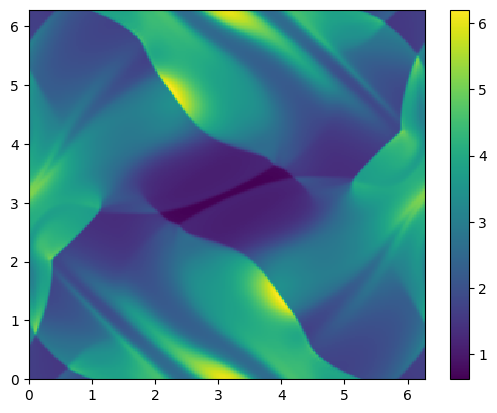

In [95]:
plt.figure()

z = plt.pcolor(x_2d, y_2d, rho)

plt.colorbar(z)

plt.show()

In [105]:
# Function to calculate the divergence
def divergence(comp1, comp2, dx, dy):

    div1 = np.gradient(comp2, dy, axis=0)  # y
    div2 = np.gradient(comp1, dx, axis=1)  # x # corrected indices 1 changed for 0

    divt = div1 + div2
    return divt  # return indices in this way [y, x]

In [111]:
# calculate the velocity divergence
div = divergence(vx1, vx2, dx, dy)  # [L/T]/[L]=[1/T]= s^-1 #consider that axis are in this way div[z,y,x]]

# Get binary map
div_clean = np.where(div >= 0, 0, 1)

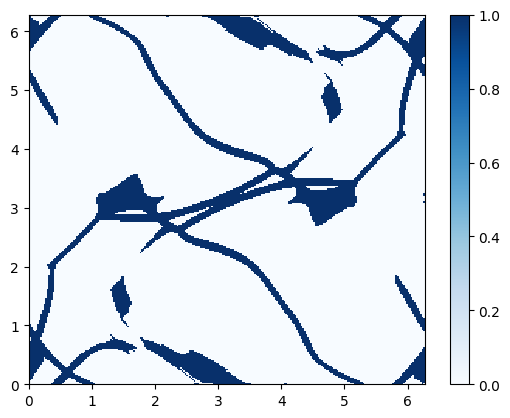

In [120]:
plt.figure()

z1 = plt.pcolor(x_2d, y_2d, div_clean, cmap = "Blues")

plt.colorbar(z1)

plt.show()

In [116]:
prs_dx, prs_dy = np.gradient(prs, dx)

modulus_gradient_prs = np.sqrt(prs_dx**2 + prs_dy**2)

mdl = (modulus_gradient_prs * dx) / prs

mdl1 = np.where(mdl > 0.1, 1., 0.)

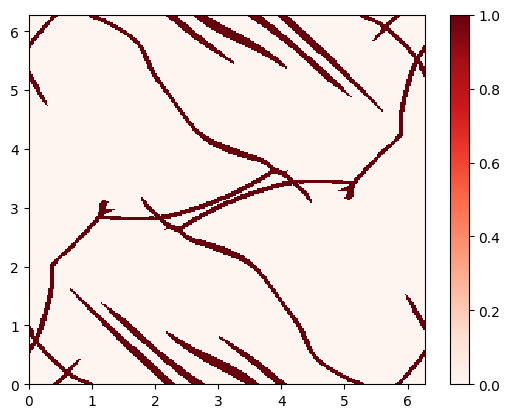

In [119]:
plt.figure()

z1 = plt.pcolor(x_2d, y_2d, mdl1, cmap = "Reds")

plt.colorbar(z1)

plt.show()

In [121]:
tagtot = div_clean * mdl1

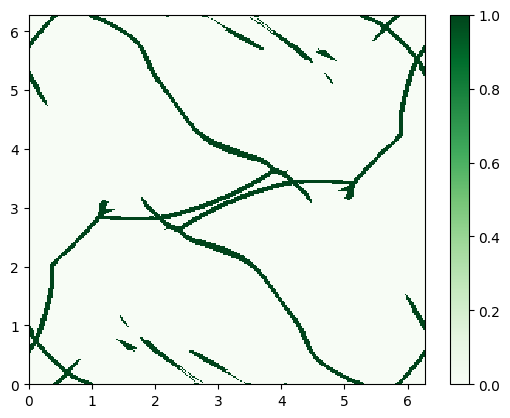

In [123]:
plt.figure()

z1 = plt.pcolor(x_2d, y_2d, tagtot, cmap = "Greens")

plt.colorbar(z1)

plt.show()

### Group Homework: Shock wave population in the Orszag-Tang vortex

We wish to study the evolution of the population of shock waves that emerge in the Orszag-Tang vortex. To do this, we need to look for grid cells that have convergent flows and/or large pressure gradients (as we did above), but now we want to do this at different times.


**Step 1** Print binary maps of the shocked cell candidates at all times. For this, you can call the above functions within a FOR loop using a time index.


**Step 2** For each time, count the number of shocked cells and then make a plot of number of shocks (in the Y axis) versus time (in the X axis). There is no need to add physical units

**Step 3** Make a GIF movie of the shock maps.


**Step 4** Challenge: If you have time, you can calculate the Mach numbers ofthe shocks using the following approach. First, you need to compute the sound speed from the pressure and density:

$$c_s=\sqrt{\gamma\frac{p}{\rho}}$$

Then, you can compute the shock Mach number:

$$M_{x,y}=\frac{-\nabla v_{x,y}(1+\gamma)+\sqrt{16c_{s}^{2}+\nabla v_{x,y}^{2}(1+\gamma)^{2}}}{4c_{s}}$$

where $\nabla v_{x,y}$ represents the directional velocity gradient, which you can compute using np.gradient().